# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [1]:
# for linux
# %sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# %brew install poppler tesseract libmagic

In [2]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.9/486.9 kB 23.0 MB/s et

In [6]:
import os
from google.colab import userdata

# keys for the services we will use

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [8]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (275 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [12]:
!pip install pytesseract

In [14]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (15.6 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123659 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [15]:
from unstructured.partition.pdf import partition_pdf

output_path = "/content/"
file_path = output_path + 'attention.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [16]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>",
 "<class 'unstructured.documents.elements.Table'>"}

In [17]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [18]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
# chunk_images[0].to_dict()

IndexError: list index out of range

In [19]:
chunk_images = [el for el in elements if 'Image' in str(type(el))]

### Separate extracted elements into tables, text, and images

In [20]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [21]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

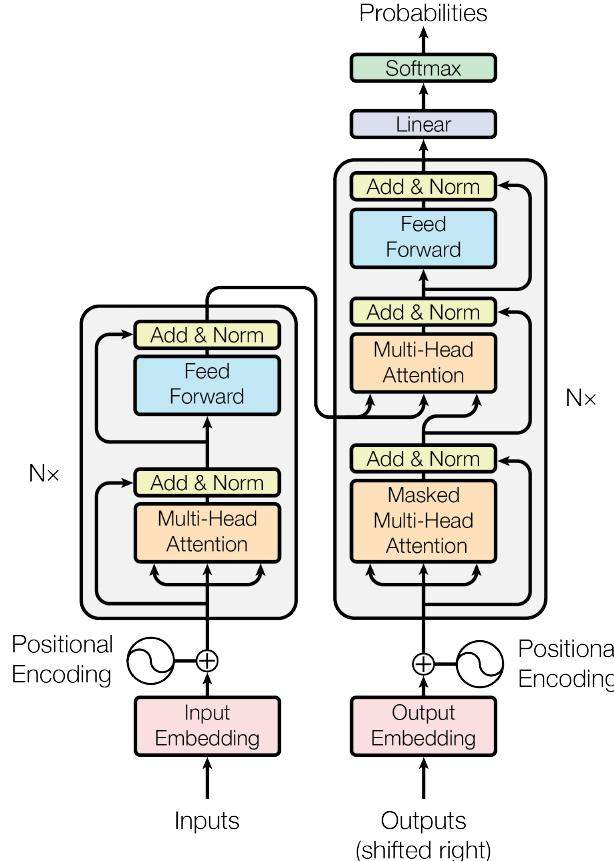

In [22]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [23]:
%pip install -Uq langchain-groq

In [24]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [25]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [26]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [27]:
text_summaries

['The authors propose the Transformer model, an attention-based architecture that replaces recurrence in sequence modeling. This model achieves state-of-the-art results in machine translation and English constituency parsing, with significant improvements in parallelization and training time.',
 'The Transformer model uses self-attention to compute input and output representations without relying on sequence-aligned RNNs or convolution, and has an encoder-decoder structure with stacked self-attention and point-wise, fully connected layers for both encoder and decoder.',
 'The Transformer model architecture consists of an encoder and decoder stack, each composed of 6 identical layers with residual connections and layer normalization. The encoder performs multi-head self-attention and position-wise feed-forward networks, while the decoder adds a third sub-layer for multi-head attention over the encoder output, with masking to prevent position i from attending to subsequent positions.',
 

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [28]:
%pip install -Uq langchain_openai

In [29]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [30]:
image_summaries

['The image illustrates the architecture of the Transformer model, commonly used in natural language processing tasks. \n\n### Structure Breakdown:\n\n1. **Input Section**:\n   - At the bottom, there\'s a box labeled "Inputs," indicating where the input data is fed into the model. This is connected to an "Input Embedding" layer, which transforms the input tokens into vector representations.\n   - A "Positional Encoding" component is linked to the input embedding, adding information about the position of each token in the sequence.\n\n2. **Encoder Block**:\n   - To the left, a series of layers are organized in a vertical stack, representing the encoder blocks. Each block consists of:\n     - **Multi-Head Attention**: This layer captures relationships between input tokens by attending to all tokens simultaneously.\n     - **Add & Norm**: Following the attention layer, there’s a residual connection (indicated by arrows) that adds the input of the layer to its output, followed by layer nor

In [31]:
print(image_summaries[1])

The image presents a schematic representation of two key concepts in the Transformers architecture: Scaled Dot-Product Attention and Multi-Head Attention.

### Left Side: Scaled Dot-Product Attention
- **Components**: 
  - The diagram consists of a vertical stack of labeled boxes.
  - **Inputs**: At the bottom, three inputs are represented: Q (Query), K (Key), and V (Value).
  - **MatMul**: The first operation is a matrix multiplication (MatMul) indicated by a purple box that takes in Q and K.
  - **Scale**: Above this, there's a yellow box labeled "Scale," which likely refers to scaling the dot products for numerical stability.
  - **Mask (opt.)**: Next, a pink box labeled "Mask (opt.)" suggests optional masking, possibly for preventing attention to certain positions (like padding tokens).
  - **SoftMax**: Following this is a green box labeled "SoftMax," which normalizes the attention scores.
  - **MatMul (Final)**: At the top, another purple box labeled "MatMul" indicates a final mat

## Load data and summaries to vectorstore

### Create the vectorstore

In [32]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

<ipython-input-32-acdcec3e4a1a>:9: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
<ipython-input-32-acdcec3e4a1a>:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())


### Load the summaries and link the to the original data

In [33]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [34]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [35]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

Parser Training WSJ 23 F1 Vinyals & Kaiser el al. (2014) WSJ only, discriminative 88.3 Petrov et al. (2006) WSJ only, discriminative 90.4 Zhu et al. (2013) WSJ only, discriminative 90.4 Dyer et al. (2016) [8] WSJ only, discriminative 91.7 Transformer (4 layers) WSJ only, discriminative 91.3 Zhu et al. (2013) semi-supervised 91.3 Huang & Harper (2009) semi-supervised 91.3 McClosky et al. (2006) semi-supervised 92.1 Vinyals & Kaiser el al. (2014) semi-supervised 92.1 Transformer (4 layers) semi-supervised 92.7 Luong et al. (2015) [23] multi-task 93.0 Dyer et al. (2016) generative 93.3

--------------------------------------------------------------------------------
7 Conclusion

In this work, we presented the eplacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention.

ps On both WMT 2014 English-to-German and WMT 2014 English-to-French translation tasks, we achieve a new state of the art. In the former task our best model outperfor

## RAG pipeline

In [36]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [37]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism is a method used in neural networks, particularly in natural language processing, to allow the model to focus on specific parts of the input data when generating outputs. It works by assigning different weights to different words or parts of a sequence, enabling the model to "attend" to relevant information, especially in the context of long-distance dependencies and anaphora resolution.

In the provided visualizations, we can see how various attention heads focus on different words in a sentence, demonstrating the mechanism's ability to capture relationships and dependencies between words. For instance, in one visualization, the attention heads highlight connections related to the verb "making," indicating how the model understands its contextual relevance in the sentence. Different colors in the visualizations represent different attention heads, showcasing the diversity of focus within the model.


Response: Multi-head attention is a mechanism that enhances the model's ability to focus on different parts of the input sequence simultaneously. Instead of using a single attention function with a fixed set of queries, keys, and values, multi-head attention projects these inputs into multiple sets, allowing the model to learn different representations from different subspaces. 

In the multi-head attention architecture, several attention heads are used in parallel, each performing the scaled dot-product attention independently. The results from these heads are then concatenated and linearly transformed to produce the final output. This approach enables the model to capture a richer set of features and relationships within the data, improving its performance on tasks like translation and sequence modeling.


Context:
7 Conclusion

In this work, we presented the eplacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention.

ps On bot

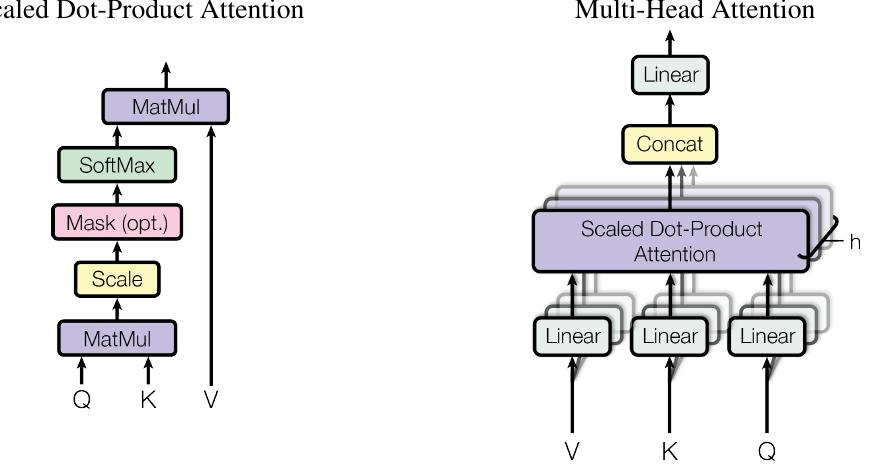

In [38]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)